<a href="https://colab.research.google.com/github/Sicily-F/wild-trade-tech/blob/main/Setting_Up_VM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Virtual machine (VM) in Microsoft Azure

This tutorial is aimed at Azure users who wish to perform small to medium sized transfers to a storage container.  

For a basic understnading 
When making a virtual machine (VM), you need to make sure that the VM is set to the same resources group as your storage account.

NB: This tutorial involves running a Linux VM in Windows PowerShell, so some of the code is only applicable to a Linux operating system 

## Overall file transfer in Azure 

For file transfer you can use [AzCopy]((https://docs.microsoft.com/en-us/azure/storage/common/storage-ref-azcopy)), a command-line utility that you can use to copy files to or from a storage account. For more information on blobs, storage accounts and containers you can [watch](https://www.youtube.com/watch?v=fQwxPqYIUfI) this video or [read](https://www.todayilearnedcloud.com/Azure-Blob-and-File-Storage-What-is-the-Difference/#:~:text=The%20Azure%20Blob%20Storage%20account%20is%20setup%20in,the%20objects%20that%20are%20stored%20in%20the%20container.) this article.

This information on the structure of how storage accounts link to containers and blobs is useful.
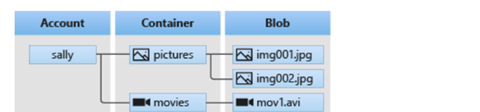

## If you need to use AzCopy to upload from your local storage to a storage container 

**Steps** 
1.   Download AzCopy and add it to your system path (D:/AzCopy in my case), more guidance [here](https://azure.microsoft.com/en-us/products/storage/storage-explorer/#overview) as well 
2.   Assign an Azure role for access to blob data within your whole account (I did all of them to a user identity)
3. Log into azcopy on the Windows PowerShell or Command prompt 
4. Rather than logging in with just the username which your Azure account is signed into, you can use your [tenant ID](https://docs.microsoft.com/en-us/azure/active-directory/fundamentals/active-directory-how-to-find-tenant)
5. The below code works with the tenant id and the ‘=’ sign and sent an email code to my email address, which allowed me to successfully log in, bear in mind this is my tenant ID 

```
azcopy login --tenant-id=XXXXXXXX 

```
6. Follow the instructions on your PowerShell screen and go to https://microsoft.com/devicelogin 

7. This will then redirect you to a new tab in your browser to go through the steps for authentication (usually involving sending an email with a one-time authentication code) 

8. Then you will be logged in to AzCopy 

9. You can make a container following the steps listed under the header [here](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-portal); I actually followed the steps in this great YouTube [video](https://www.youtube.com/watch?v=ZLPQRJZEo_E)

An example of this AzCopy *in use* is, whereby the argument in “” is the file path to the folder I’d like to transfer which contain blobs (in this case image files), and this is linked to the birdphotos storage account, which contains the new container I made called testcontainer.
```
azcopy copy “F:/git/common_myna” https://birdphotos.blob.core.windows.net/testcontainer/ --recursive 
```



## Connecting to your VM using Windows PowerShell
-	You can create an SSH key separately and then download the associated .pem file to somewhere on your local system, a .pem file is a type of Public Key Infrastructure (PKI) file used for keys and certificates
-	You can create the .pem file in your VM following the steps [here](https://docs.microsoft.com/en-us/azure/virtual-machines/ssh-keys-portal)

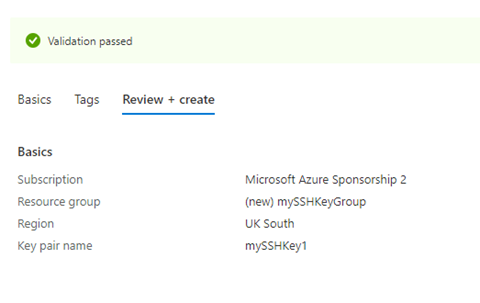
```
ssh -i D:/mySSHKey1.pem username@XX.XX.XX.XX

```
-	For example, in my case, I specified where my .pem file was on my local storage system and the IP address for my VM, then you will be prompted to enter the VM-specific password (which could be different from your Azure login details)

## Mounting and partitioning a data disk
-	You can use  “AzCopy” copy to transfer files from Azure Blob Storage directly to VM SSD drive. This [link](https://social.msdn.microsoft.com/Forums/sqlserver/en-US/4b1653d5-0a63-4f92-8a9c-02e78dd2d8c0/transferring-files-from-azure-blob-storage-directly-to-vm-ssd-drive?forum=windowsazuredata) may be useful.
- You may need the Access key for your storage account to do this: see the section on ‘View account access keys’ [here](https://docs.microsoft.com/en-us/azure/storage/common/storage-account-keys-manage?tabs=azure-portal)
-	*However*, here we will mount and partition a data disk, and then transfer files using a SCP (secure copy protocol) client


## Steps
1.	We created a new disk in the Azure portal – look at the instructions under the headings: ‘Find the virtual machine’ and ‘Attach a new disk’ here: Attach a data disk to a Linux VM - Azure Virtual Machines | Microsoft Docs – we chose a disk of  size100 GB
2.	Then you can use SSH to log into your VM on Windows PowerShell
3.	You can find the new disk by typing the following into your PowerShell
```
lsblk -o NAME,HCTL,SIZE,MOUNTPOINT | grep -i "sd"
```
4.	From the output, you will be able to see the code for the drive you added (mine was called sda, and it matched the size of 100 GB, which is what I set it as in the Azure portal)



### Partitioning the disk
5.	You can partition your disk using the below code in your PowerShell


```
sudo parted /dev/sda --script mklabel gpt mkpart xfspart xfs 0% 100%
sudo mkfs.xfs /dev/sda1
sudo partprobe /dev/sda1
```





### Mounting the disk
6.	Now you need to mount the disk onto a data drive on your VM


```
sudo mkdir /datadrive
sudo mount /dev/sda1 /datadrive
```
-	NB: the base tutorial for this was followed, except for the section on opening the /etc/fstab file in a text editor in Nano- this was because the UUID was already specified in our file

7.	Running the below code lets you check that the disk has been correctly mounted – it should be mounted at  /datadrive.


```
lsblk -o NAME,HCTL,SIZE,MOUNTPOINT | grep -i "sd"
```

## Giving VM’s access to data
-	After mounting a new data drive, you can download an SCP client (similar to the Windows File Explorer), the steps below are modified from [here](https://winscp.net/eng/docs/guide_microsoft_azure)

1.	Firstly, you need to connect to your VM
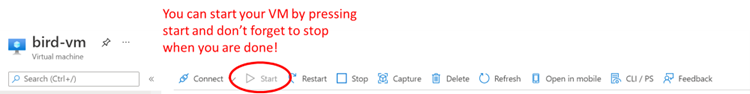


2.	Next you need to configure the DNS name for your VM, it ended up looking like this for me: 

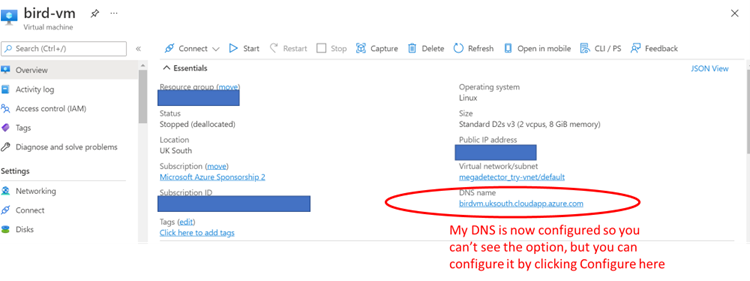

birdvm.uksouth.cloudapp.azure.com
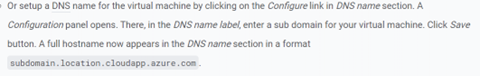

3.	To enter a new site into your Windows SCP
- Make sure New site node is selected.
- On the New site node, make sure SFTP protocol is selected.
- Enter Host name.
- Enter User name.
- Enter a password for the username. Or specify a private key, if you set up a public key authentication..
- Save your site settings using the Save button.
Login using the Login button
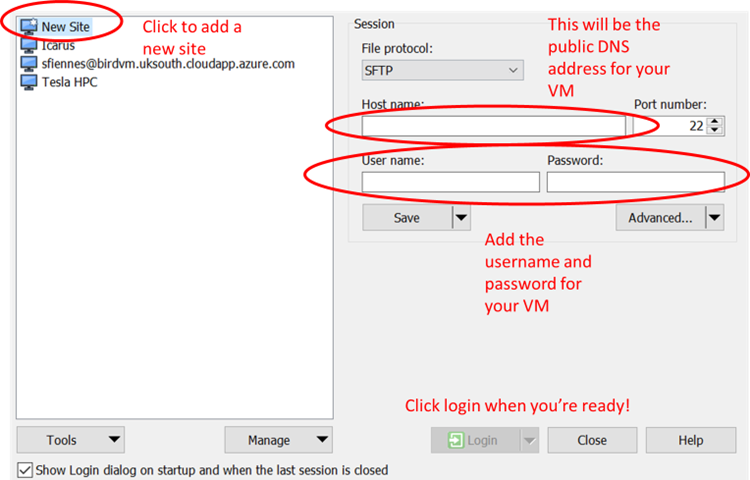


My username to enter in the SCP was the username which my VM appears under when I log onto it on Windows PowerShell, and my password I set for the VM, on port 22.

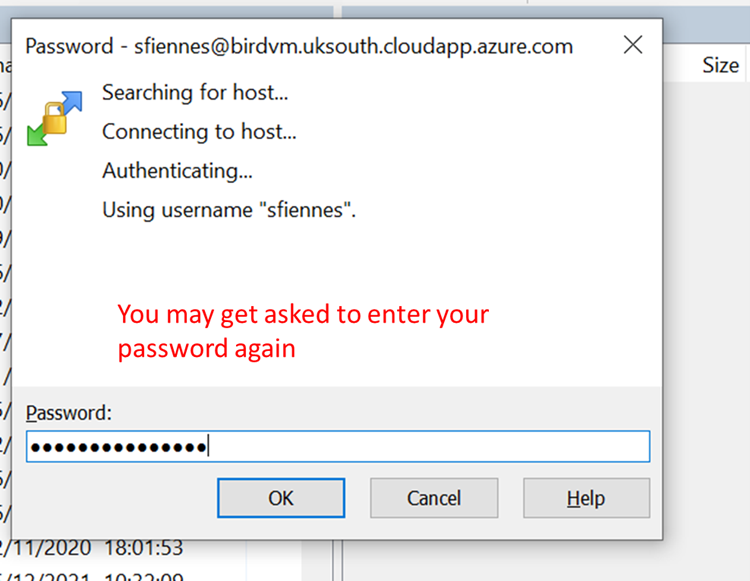

4.	When you log in on the app WinSCP again after set up, you just need to re-enter your password


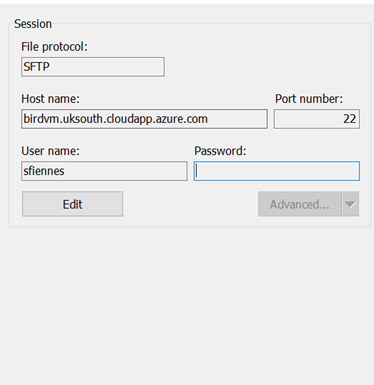

5.	You can now copy across files from your local system to the VM directly, by dragging folders across

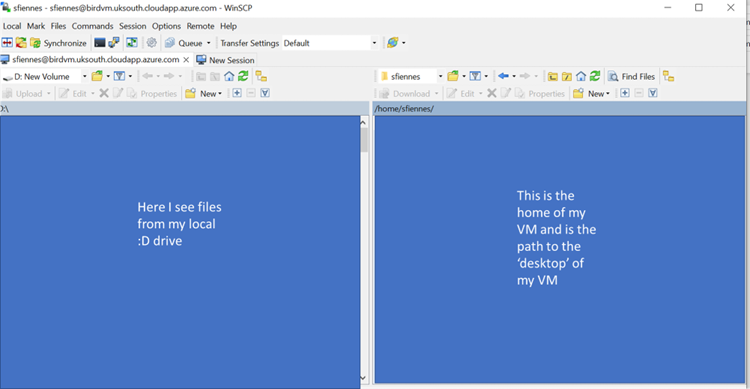

6.	The Linux VM I made already had python, though this was accessed by typing python3 into the command line
o	You can do exit() or Ctrl D to exit Python from a Command Line Interface like WindowsPowershell
7.	You can download pipi by running the following lines of code. I had some issues downloading pip, so if you follow these troubleshooting steps instead, you should be fine

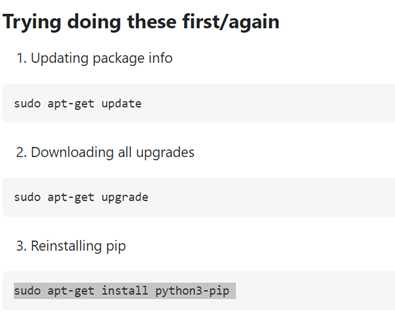

**Then you should be good to go with running Python scripts and accessing data from a VM on Azure!**